# Resampling strategies
- Create new values for high-traffic train stations

Proposed solutions:
- Generate synthetic data using SMOTE
- Use a GAN to generate synthetic data
- Copy the data from the high-traffic stations


In [40]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN

from helpers import plot_variable_importance, write_metrics_in_csv, plot_ypred_vs_yreal

In [41]:
# Open dataset
filename: str = '../dataRead_processed.pkl.bz2'
dataset = pd.read_pickle(filename, compression='bz2')

In [42]:
# Drop columns that are not needed
dataset = dataset.drop(columns=[
    'city_attraction_area',
    'non_scholarized_15_years_old_or_more_2020',
    ])

In [43]:
def remove_outliers_iqr(df: pd.DataFrame, threshold=10) -> pd.DataFrame:
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Calculer le premier et le troisième quartile
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    
    # Calculer l'IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Définir les bornes inférieures et supérieures pour chaque colonne
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Créer des masques pour les valeurs aberrantes
    lower_mask = (df[numeric_cols] >= lower_bound)
    upper_mask = (df[numeric_cols] <= upper_bound)
    
    # Garder seulement les lignes sans valeurs aberrantes
    mask = lower_mask & upper_mask
    df_no_outliers = df[mask.all(axis=1)]
    
    return df_no_outliers

dataset_no_outliers = remove_outliers_iqr(dataset)
print(f"Dataframe shape before removing outliers: {dataset.shape}")
print(f"Dataframe shape after removing outliers: {dataset_no_outliers.shape}")

Dataframe shape before removing outliers: (2226, 26)
Dataframe shape after removing outliers: (1153, 26)


In [44]:
# Remove rows if the target variable is greater than 99% of the data
dataset_no_outliers = dataset_no_outliers[dataset_no_outliers['total_passengers_2022'] < dataset_no_outliers['total_passengers_2022'].quantile(0.9)]

In [45]:
import numpy as np

def add_noise(data, noise_level=1e-2):
    int_cols = data.select_dtypes(include=[np.int64]).columns
    float_cols = data.select_dtypes(include=[np.float64]).columns
    
    for col in int_cols:
        noise = np.ceil(np.random.normal(0, noise_level * data[col].std(), size=data[col].shape).astype(int))
        data.loc[:, col] += noise
    
    for col in float_cols:
        noise = np.random.normal(0, noise_level * data[col].std(), size=data[col].shape)
        data.loc[:, col] += noise
    
    return data

def random_oversampling(dataset: pd.DataFrame, seuil: int, n_samples):
    minority_dataset = dataset[dataset['total_passengers_2022'] > seuil]
    random_indices = np.random.choice(minority_dataset.shape[0], size=n_samples, replace=True)
    selected_element = minority_dataset.iloc[random_indices]
    
    selected_elements_noisy = add_noise(selected_element)

    dataset_resampled = pd.concat([dataset, selected_elements_noisy], ignore_index=True)
    
    return dataset_resampled

# dataset_no_outliers_synthetized = dataset_no_outliers
dataset_no_outliers_synthetized = random_oversampling(dataset_no_outliers, seuil=10000, n_samples=250)


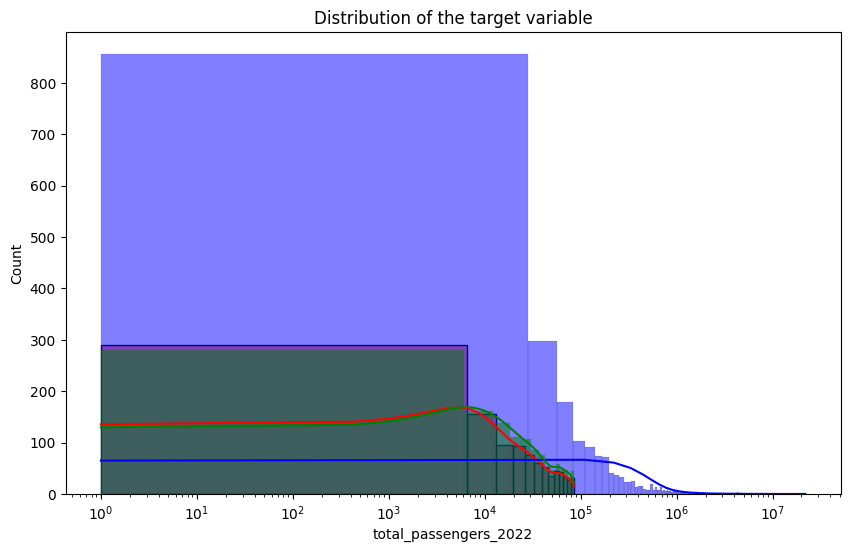

In [46]:
# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(dataset_no_outliers['total_passengers_2022'], kde=True, alpha=0.5, color='red')
sns.histplot(dataset['total_passengers_2022'], kde=True, alpha=0.5, color='blue')
sns.histplot(dataset_no_outliers_synthetized['total_passengers_2022'], kde=True, alpha=0.5, color='green')
plt.title('Distribution of the target variable')
# Echelle log
plt.xscale('log')
plt.show()

In [47]:
# Split the dataset into features and target variable
X = dataset_no_outliers_synthetized.drop('total_passengers_2022', axis=1)
y = dataset_no_outliers_synthetized['total_passengers_2022']


In [48]:
# Count the numnber of rows in each slice of the target variable ber bin
y_bins = pd.cut(y, bins=10)
y_bins.value_counts()

total_passengers_2022
(-84.746, 8575.6]     341
(8575.6, 17150.2]     210
(17150.2, 25724.8]    162
(25724.8, 34299.4]    140
(34299.4, 42874.0]    105
(51448.6, 60023.2]     82
(60023.2, 68597.8]     67
(42874.0, 51448.6]     65
(68597.8, 77172.4]     60
(77172.4, 85747.0]     55
Name: count, dtype: int64

In [49]:
# Last preprocessing steps
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

# Prepare the final preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])


,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,linear_regression,{'tuning': None},9.764580e+07,7414.303699,5348.047884,0.842926


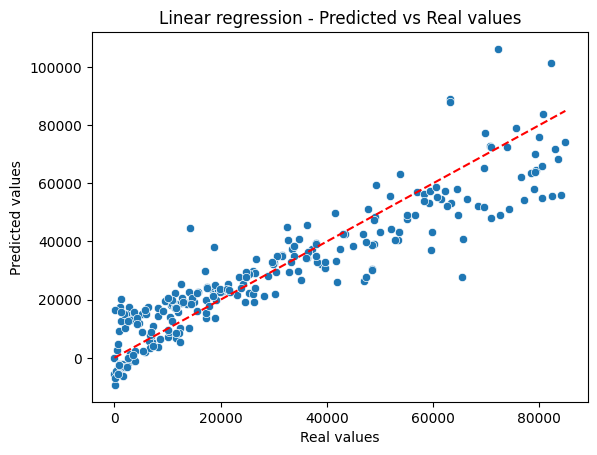

In [50]:

# Create the final pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Separate the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the target variable
y_pred = model.predict(X_test)

# Write metrics in a csv file
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plot_ypred_vs_yreal(y_pred, y_test, 'Linear regression', False, True)

write_metrics_in_csv(y_pred,
                     y_test,
                     'linear_regression',
                     {'tuning': None}
                     )

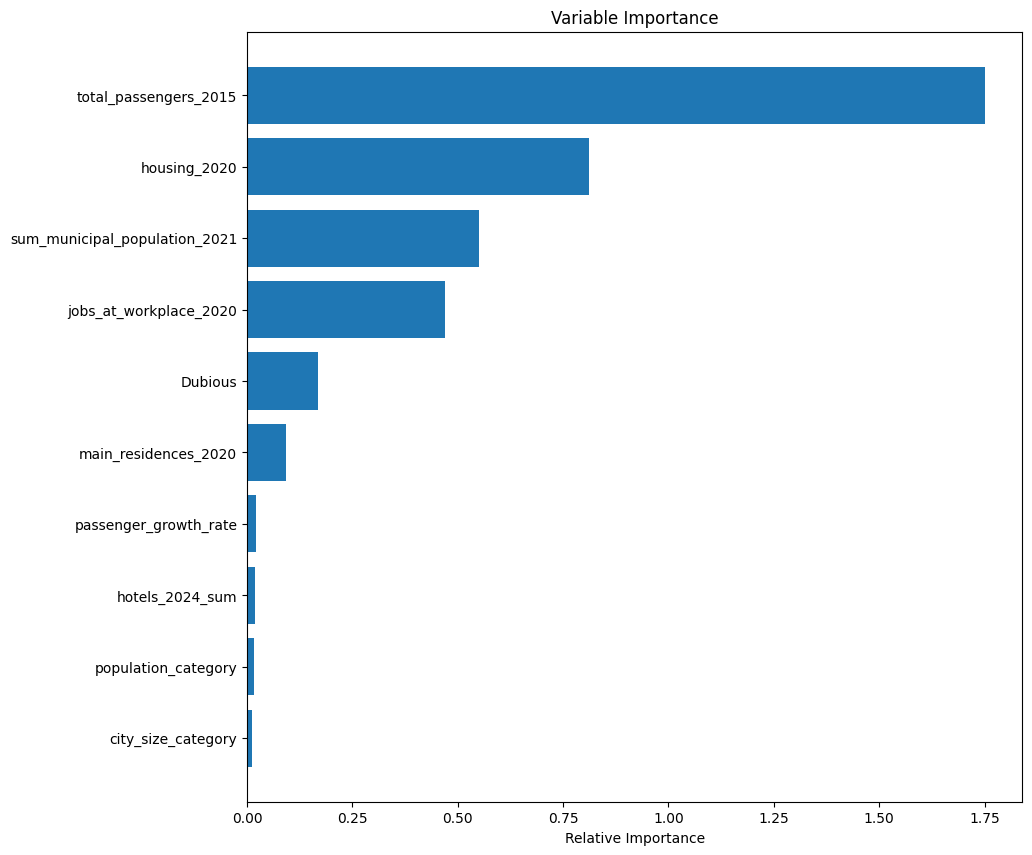

In [51]:
plot_variable_importance(model, X_train, y_train, 10)


,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,linear_regression,{'tuning': None},4.232696e+10,54041.449279,20135.87193,0.968842


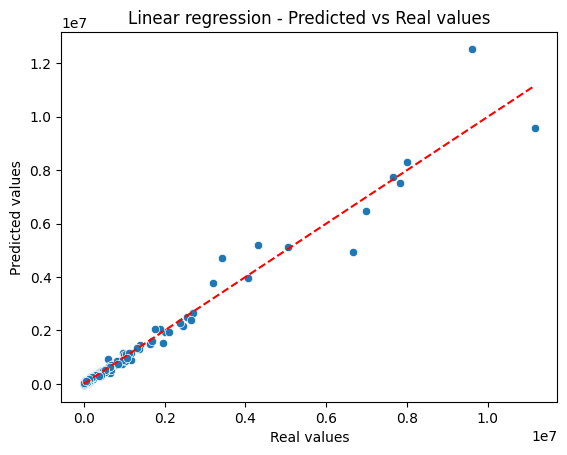

In [52]:

# Create the final pipeline
model_no_synth = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the dataset into features and target variable
X = dataset.drop('total_passengers_2022', axis=1)
y = dataset['total_passengers_2022']


# Separate the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_no_synth.fit(X_train, y_train)

# Predict the target variable
y_pred = model_no_synth.predict(X_test)

# Write metrics in a csv file
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plot_ypred_vs_yreal(y_pred, y_test, 'Linear regression', False, True)

write_metrics_in_csv(y_pred,
                     y_test,
                     'linear_regression',
                     {'tuning': None}
                     )

In [53]:
plot_variable_importance(model_no_synth, X_train, y_train, 10)

KeyboardInterrupt: 

In [ ]:
X_processed = preprocessor.fit_transform(X)

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1